## Librerías

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression

## Data

In [7]:
# Time: 4 seconds
df_inmuebles = pd.read_csv('../Data/inmuebles_full.csv')

In [8]:
# Create the geometry of the point - from longitud and latitud columns
# df_inmuebles['geometry'] = gpd.points_from_xy(x=df_inmuebles['longitud'], y=df_inmuebles['latitud'])

# Create a new variable precio por m2
df_inmuebles['precio_m2'] = df_inmuebles['precio'] / df_inmuebles['area']

# Make it a GeoDataFrame
# df_inmuebles = gpd.GeoDataFrame(df_inmuebles, geometry='geometry')

# Filtrar filas sin habitaciones, al ser una de las variables claves no se analizan posibles imputaciones para no dañar la muestra
df_inmuebles = df_inmuebles[~df_inmuebles['habitaciones'].isna()]

# Habitaciones como entero
df_inmuebles['habitaciones'] = df_inmuebles['habitaciones'].astype('int64')

# Solo negocios de venta
df_inmuebles = df_inmuebles[df_inmuebles['tiponegocio'] == 'venta']

# Drop useless columns
df_inmuebles.drop(['latitud', 'longitud', 'fecha_creacion', 'direccion', 'tiponegocio'], axis=1, inplace=True)

# Drop Departamento
df_inmuebles.drop('departamento', axis=1, inplace=True)

# Filtrar los municipios importantes (80%)
a = df_inmuebles.groupby(['municipio']).agg(count=('id', 'count')).sort_values(by='count', ascending=False)
a['perc'] = a['count'] / a['count'].sum()
a['cum_perc'] = a['perc'].cumsum()
a['filtro'] = 0
a.loc[a['cum_perc'] <= 0.8, 'filtro'] = 1
a.reset_index(inplace=True)
df_inmuebles = pd.merge(
    df_inmuebles,
    a[['municipio', 'filtro']],
    how='left',
    on='municipio',
)
df_inmuebles = df_inmuebles[df_inmuebles['filtro'] == 1]
df_inmuebles.drop('filtro', axis=1, inplace=True)

# Filtrar las filas con 0 habitaciones y más de 10 habitaciones
df_inmuebles = df_inmuebles[(df_inmuebles['habitaciones'] >= 1) & ((df_inmuebles['habitaciones'] <= 5))]

# Banos se queda igual

# Filtrar outliers de Area
Q1 = df_inmuebles['area'].quantile(0.25)
Q2 = df_inmuebles['area'].quantile(0.50)
Q3 = df_inmuebles['area'].quantile(0.75)
IQR = Q3 - Q1
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR
df_inmuebles = df_inmuebles[(df_inmuebles['area'] >= 20) & (df_inmuebles['area'] <= upper_whisker)]

# Num Ascensores se queda igual

# Filtrar los inmuebles con más de 2 garajes
df_inmuebles = df_inmuebles[(df_inmuebles['garajes'] >= 0) & (df_inmuebles['garajes'] <= 2)]

# Anos antiguedad se queda igual

# Tipo Inmueble se queda igual

# Filtrar precios outliers
Q1 = df_inmuebles['precio'].quantile(0.25)
Q2 = df_inmuebles['precio'].quantile(0.50)
Q3 = df_inmuebles['precio'].quantile(0.75)
IQR = Q3 - Q1
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR
df_inmuebles = df_inmuebles[(df_inmuebles['precio'] >= 100e6) & (df_inmuebles['precio'] <= upper_whisker)]

# Filtrar precio_m2 outliers
Q1 = df_inmuebles['precio_m2'].quantile(0.25)
Q2 = df_inmuebles['precio_m2'].quantile(0.50)
Q3 = df_inmuebles['precio_m2'].quantile(0.75)
IQR = Q3 - Q1
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR
df_inmuebles= df_inmuebles[df_inmuebles['precio_m2'] <= 10e6]

# Quitar columnas
df_inmuebles.drop(['id'], axis=1, inplace=True)

categoricas = ['municipio', 'tipo_inmueble']
numericas = ['habitaciones', 'banos', 'num_ascensores', 'garajes', 'area', 'anos_antiguedad']
precios = ['precio', 'precio_m2']
df_inmuebles = df_inmuebles[categoricas + numericas + precios]

In [9]:
df_inmuebles

,municipio,tipo_inmueble,habitaciones,banos,num_ascensores,garajes,area,anos_antiguedad,precio,precio_m2
0,CALI,apartamento,3,2,0,1,81.0,12,264000000.0,3.259259e+06
1,SABANETA,apartamento,2,3,1,2,90.0,4,460000000.0,5.111111e+06
8,CALI,apartamento,3,2,1,1,90.0,4,320000000.0,3.555556e+06
15,SABANETA,apartamento,3,3,1,2,106.0,4,541000000.0,5.103774e+06
17,PEREIRA,apartamento,3,2,1,1,70.0,4,270000000.0,3.857143e+06
...,...,...,...,...,...,...,...,...,...,...
633859,CALI,casa,4,5,0,2,216.0,12,680000000.0,3.148148e+06
633862,CALI,apartamento,3,2,0,2,75.0,4,450000000.0,6.000000e+06
633864,CALI,apartamento,3,3,0,2,113.0,4,560000000.0,4.955752e+06
633867,CALI,casa,3,5,0,2,164.0,12,785000000.0,4.786585e+06


In [10]:
df_inmuebles.columns

Index(['municipio', 'tipo_inmueble', 'habitaciones', 'banos', 'num_ascensores',
       'garajes', 'area', 'anos_antiguedad', 'precio', 'precio_m2'],
      dtype='object')

## Preprocessing

In [11]:
# Handling categorical variables
categorical_features = ['municipio', 'tipo_inmueble']
numeric_features = ['habitaciones', 'banos', 'num_ascensores', 'garajes', 'area', 'anos_antiguedad']

# Separating features and target variable
X = df_inmuebles[categorical_features + numeric_features]
y = df_inmuebles['precio_m2']
y = df_inmuebles['precio']


# Encoding categorical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', 'passthrough', numeric_features),
    ]
)

## Train and Test Split

In [12]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

In [13]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((281154, 8), (120495, 8), (281154,), (120495,))

## Create Pipeline

In [97]:
# Create a pipeline
pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestRegressor(
                n_estimators=50,
                random_state=42,
                max_features='sqrt',
                max_depth=30,
                min_samples_split=2,
                min_samples_leaf=1,
            )
        )
    ]
)

## Train the Model

In [98]:
# Training the model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['municipio',
                                                   'tipo_inmueble']),
                                                 ('num', 'passthrough',
                                                  ['habitaciones', 'banos',
                                                   'num_ascensores', 'garajes',
                                                   'area',
                                                   'anos_antiguedad'])])),
                ('model',
                 RandomForestRegressor(max_depth=30, max_features='sqrt',
                                       n_estimators=50, random_state=42))])

In [16]:
# from joblib import dump, load
# dump(pipeline, 'gbr_precio_m2_trained_model.joblib')

In [17]:
# from joblib import dump, load
# pipeline = load('../Models/gbr_trained_model.joblib')

In [18]:
# pipeline

## Predict

In [99]:
# Making predictions
y_pred_precio_m2 = pipeline.predict(X_test)

In [100]:
y_pred_precio = y_pred_precio_m2 * X_test['area']
y_test_precio = y_test * X_test['area']
y_pred_precio = y_pred_precio_m2
y_test_precio = y_test

## Evaluate

### Precio

In [101]:
# Evaluating the model
mse = mean_squared_error(y_test_precio, y_pred_precio)
rmse = root_mean_squared_error(y_test_precio, y_pred_precio)
mape = mean_absolute_percentage_error(y_test_precio, y_pred_precio)
r2 = r2_score(y_test_precio, y_pred_precio)

print(f'Mean Squared Error (MSE): {"{:,}".format(mse)}')
print(f'Root Mean Squared Error (RMSE): {"{:,}".format(rmse)}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'R^2 Score: {r2}')

Mean Squared Error (MSE): 7,161,599,018,377,945.0
Root Mean Squared Error (RMSE): 84,626,231.2665402
Mean Absolute Percentage Error (MAPE): 0.1436295348252353
R^2 Score: 0.8291564927793817


In [22]:
# df_results = pd.DataFrame(
#     {
#         'y_test': y_test_precio,
#         'y_pred': y_pred_precio,
#         'habitaciones': X_test['habitaciones'],
#     }
# )
# df_results.sort_values(by='y_test', ascending=True, inplace=True)
# df_results.reset_index(drop=True, inplace=True)

In [32]:
df_results = X_test.copy()
df_results['y_test'] = y_test_precio
df_results['y_pred'] = y_pred_precio
df_results['error'] = y_test_precio - y_pred_precio
df_results.sort_values(by='y_test', ascending=True, inplace=True)
df_results.reset_index(drop=True, inplace=True)

In [33]:
df_results

,municipio,tipo_inmueble,habitaciones,banos,num_ascensores,garajes,area,anos_antiguedad,y_test,y_pred,error
0,SAN JOSÉ DE CÚCUTA,apartamento,1,1,0,1,43.0,23,1.000000e+08,1.424892e+08,-4.248920e+07
1,SAN JOSÉ DE CÚCUTA,apartamento,3,2,0,1,56.0,23,1.000000e+08,1.254210e+08,-2.542096e+07
2,MEDELLÍN,apartamento,3,1,0,1,48.0,4,1.000000e+08,1.525660e+08,-5.256605e+07
3,CALI,apartamento,2,1,0,1,40.0,4,1.000000e+08,1.372049e+08,-3.720492e+07
4,"BOGOTÁ, D.C.",apartamento,2,1,0,1,45.0,12,1.000000e+08,1.568255e+08,-5.682551e+07
...,...,...,...,...,...,...,...,...,...,...,...
120490,"BOGOTÁ, D.C.",apartamento,4,5,0,2,186.0,1,1.060000e+09,8.541407e+08,2.058593e+08
120491,ENVIGADO,casa,3,5,0,2,212.0,12,1.060000e+09,8.793757e+08,1.806243e+08
120492,"BOGOTÁ, D.C.",apartamento,3,4,1,2,119.0,1,1.061000e+09,7.429362e+08,3.180638e+08
120493,"BOGOTÁ, D.C.",apartamento,2,3,1,2,140.0,12,1.065000e+09,8.433486e+08,2.216514e+08


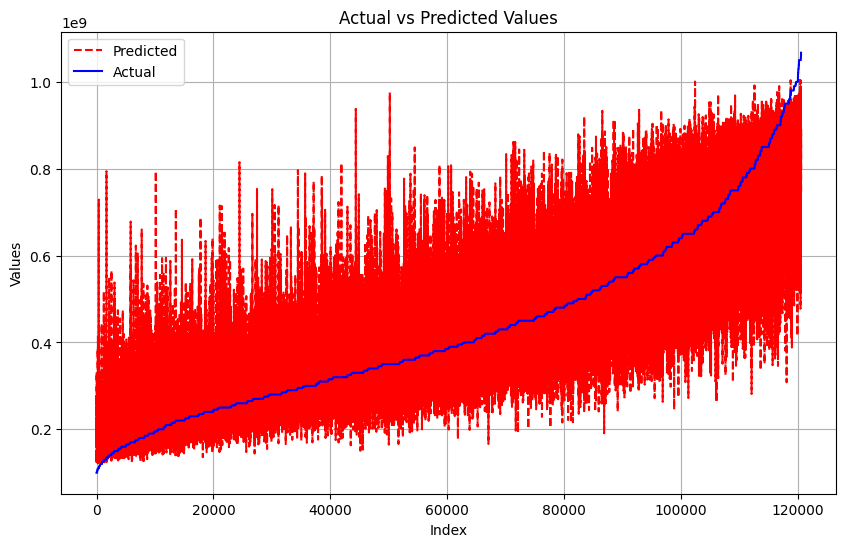

In [34]:
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(df_results.index, df_results['y_pred'], label='Predicted', color='r', linestyle='--')
plt.plot(df_results.index, df_results['y_test'], label='Actual', color='b')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()

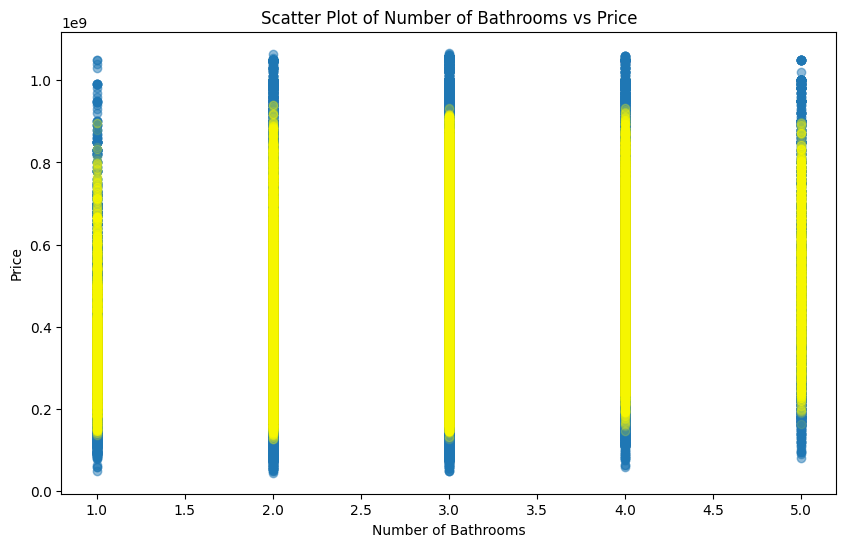

In [45]:
plt.figure(figsize=(10, 6))
plt.scatter(df_results['habitaciones'], df_results['y_test'], alpha=0.5)
plt.scatter(df_results['habitaciones'], df_results['y_pred'], alpha=0.1, c='yellow')
# plt.scatter(df_results['habitaciones'], df_results['error'], alpha=0.1, c='red')

# Adding title and labels
plt.title('Scatter Plot of Number of Bathrooms vs Price')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Price')

# Show plot
plt.show()

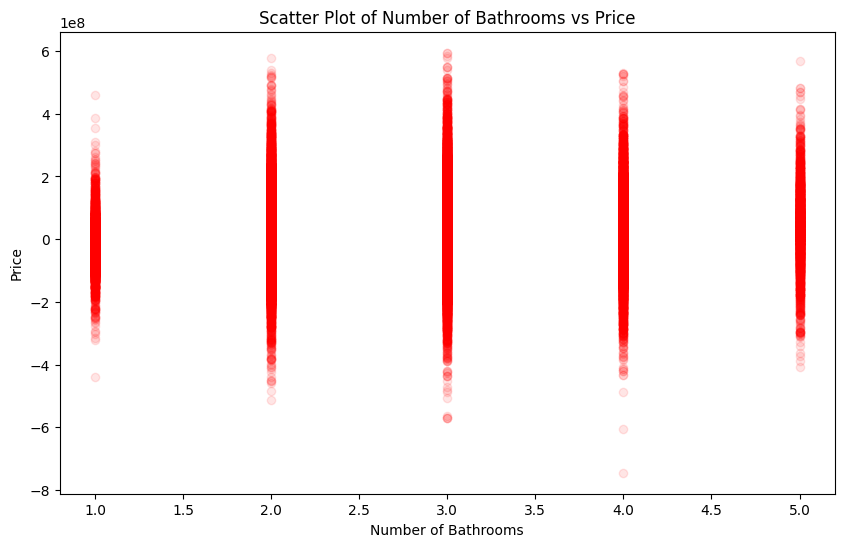

In [33]:
plt.figure(figsize=(10, 6))
# plt.scatter(df_results['banos'], df_results['y_test'], alpha=0.5)
# plt.scatter(df_results['banos'], df_results['y_pred'], alpha=0.1, c='red')
plt.scatter(df_results['banos'], df_results['error'], alpha=0.1, c='red')

# Adding title and labels
plt.title('Scatter Plot of Number of Bathrooms vs Price')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Price')

# Show plot
plt.show()

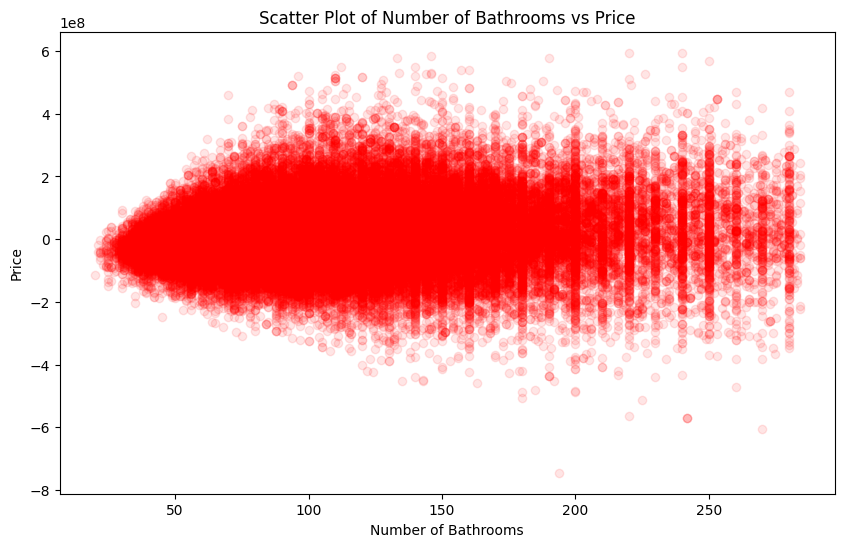

In [34]:
plt.figure(figsize=(10, 6))
# plt.scatter(df_results['area'], df_results['y_test'], alpha=0.5)
# plt.scatter(df_results['area'], df_results['y_pred'], alpha=0.1, c='red')
plt.scatter(df_results['area'], df_results['error'], alpha=0.1, c='red')

# Adding title and labels
plt.title('Scatter Plot of Number of Bathrooms vs Price')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Price')

# Show plot
plt.show()

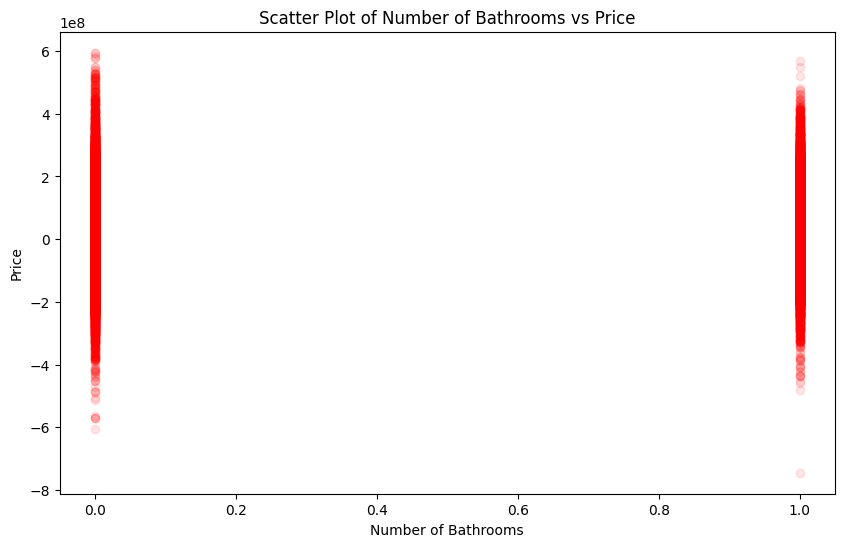

In [36]:
plt.figure(figsize=(10, 6))
# plt.scatter(df_results['num_ascensores'], df_results['y_test'], alpha=0.5)
# plt.scatter(df_results['num_ascensores'], df_results['y_pred'], alpha=0.1, c='red')
plt.scatter(df_results['num_ascensores'], df_results['error'], alpha=0.1, c='red')

# Adding title and labels
plt.title('Scatter Plot of Number of Bathrooms vs Price')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Price')

# Show plot
plt.show()

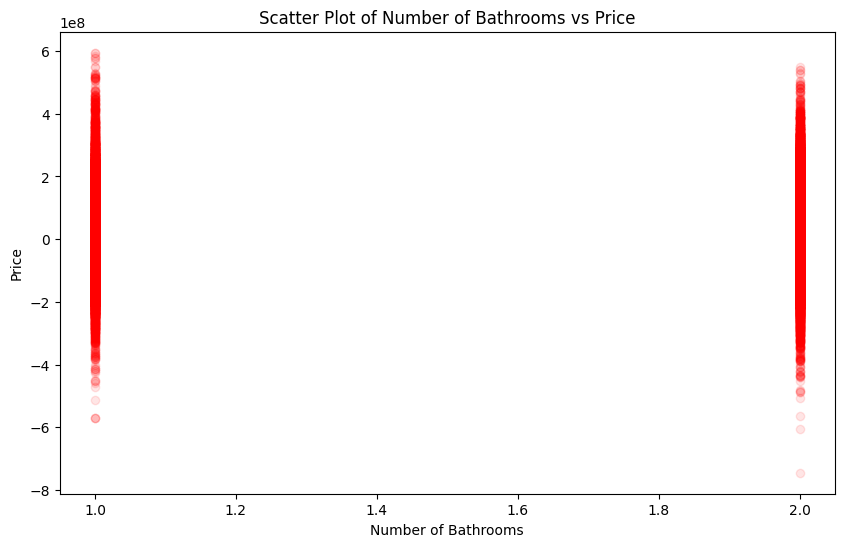

In [37]:
plt.figure(figsize=(10, 6))
# plt.scatter(df_results['garajes'], df_results['y_test'], alpha=0.5)
# plt.scatter(df_results['garajes'], df_results['y_pred'], alpha=0.1, c='red')
plt.scatter(df_results['garajes'], df_results['error'], alpha=0.1, c='red')

# Adding title and labels
plt.title('Scatter Plot of Number of Bathrooms vs Price')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Price')

# Show plot
plt.show()

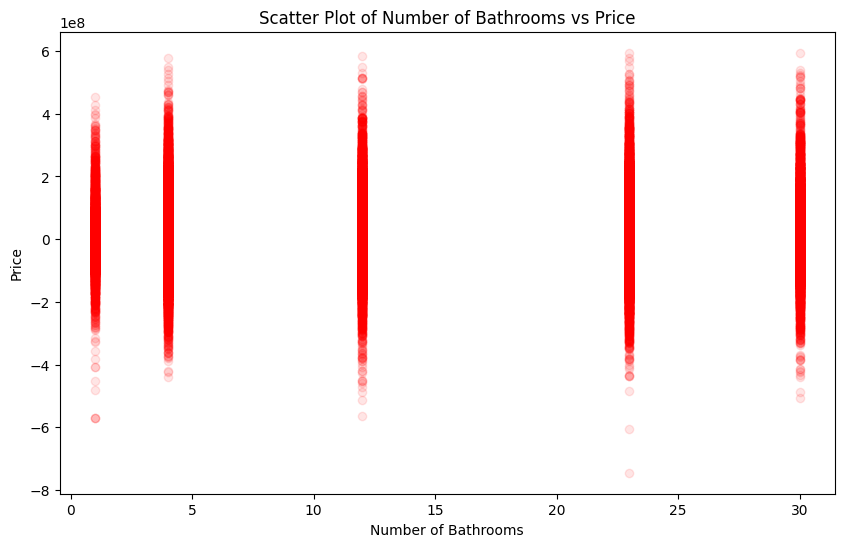

In [38]:
plt.figure(figsize=(10, 6))
# plt.scatter(df_results['anos_antiguedad'], df_results['y_test'], alpha=0.5)
# plt.scatter(df_results['anos_antiguedad'], df_results['y_pred'], alpha=0.1, c='red')
plt.scatter(df_results['anos_antiguedad'], df_results['error'], alpha=0.1, c='red')

# Adding title and labels
plt.title('Scatter Plot of Number of Bathrooms vs Price')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Price')

# Show plot
plt.show()

### Precio M2

In [50]:
# Evaluating the model
mse = mean_squared_error(y_test_precio, y_pred_precio)
rmse = root_mean_squared_error(y_test_precio, y_pred_precio)
mape = mean_absolute_percentage_error(y_test_precio, y_pred_precio)
r2 = r2_score(y_test_precio, y_pred_precio)

print(f'Mean Squared Error (MSE): {"{:,}".format(mse)}')
print(f'Root Mean Squared Error (RMSE): {"{:,}".format(rmse)}')
print(f'Mean Absolute Percentage Error (MAPE): {mape}')
print(f'R^2 Score: {r2}')

Mean Squared Error (MSE): 8,434,148,473,251,630.0
Root Mean Squared Error (RMSE): 91,837,620.14148466
Mean Absolute Percentage Error (MAPE): 0.17870844335130054
R^2 Score: 0.827621665668762


In [51]:
df_results = pd.DataFrame(
    {
        'y_test': y_test_precio,
        'y_pred': y_pred_precio,
    }
)
df_results.sort_values(by='y_test', ascending=True, inplace=True)
df_results.reset_index(drop=True, inplace=True)

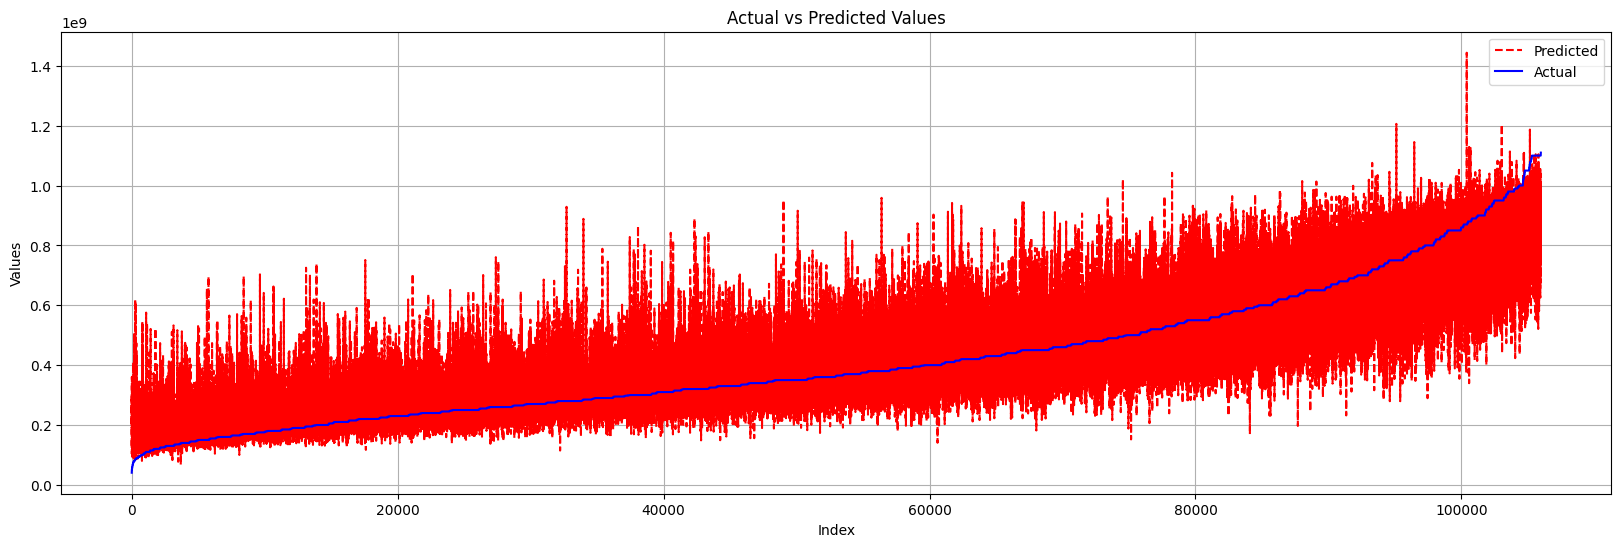

In [52]:
# Plotting the data
plt.figure(figsize=(20, 6))
plt.plot(df_results.index, df_results['y_pred'], label='Predicted', color='r', linestyle='--')
plt.plot(df_results.index, df_results['y_test'], label='Actual', color='b')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()